# Property of FastMap on Graph

This experiments note used to analyze the property of FastMap algorithm on (directed) graphs. We will try to figure which structure can be handled by FastMap well (approximate the target value more accurate), and on the other side, which structures will be disasters for FastMap algorithm.

See [here](https://github.com/ZhiruiFeng/playground/blob/master/FastMap/FastMap.ipynb) for some backgrounds about fastmap.

1. FastMap tender to overestimate or underestimate the target value?
    - For different norms: $L_1$ and $L_2$
    - For different targets: `max` and `average` in directed graph, `distance` in undirected graph.
    - It's relationship with the dimention of embedding in the target space.
2. Is there a theoretical bound on the traditional data mining version of FastMap?

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max, difastmap_average_limitstorage, difastmap_max_limitstorage 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

**Functions for preparing the graph:**

In [7]:
def outputinfo_di(G):
    utils.connectivity_info(G)
    countn = G.number_of_nodes()
    counte = G.number_of_edges()
    density = float(counte)/(countn * (countn-1))
    print(countn)
    print(counte)
    print(density)

def outputinfo(G):
    utils.connectivity_info(G)
    countn = G.number_of_nodes()
    counte = G.number_of_edges()
    density = float(counte)/(countn * (countn-1) / 2.0)
    print(countn)
    print(counte)
    print(density)
    
def get_dijkstra_path_length_sub(G, S):
    subset = sample(list(G.nodes()), S)
    dijkstra_path_length = {}
    i = 0
    for node in subset:
        if i%(S/100) == 0:
            sys.stdout.write("\r Path length calculation: {}%".format(i/(S/100)))
        i+=1
        length = nx.single_source_dijkstra_path_length(G, node)
        dijkstra_path_length[node] = {}
        for theother in subset:
            dijkstra_path_length[node][theother] = length[theother]
    sys.stdout.write("\r Path length calculation: 100.0%")
    return dijkstra_path_length, subset

def thedistance_info(dijkstra_path_length, subset):
    dis = []
    for n1 in subset:
        dis.extend(dijkstra_path_length[n1].values())
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count')
    plt.title('Statistic of pair distances')
    plt.show()

**Functions for analyzing:**

Since we use multiprocessing to speed up, which shares some global variable, thus the functions are not defined in library.

In [9]:
###################### For average and max

def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

################ For min

def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = dijkstra_path_length[node_2][node_1]
        target_dis = min(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

################## For differential heuristic

def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

#################### For DIG-FastMap

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

## Test distortion's relation with $K$

Density: 0.007033033033033033
A strongly connected graph.
1000
7026
0.007033033033033033
 Path length calculation: 100.0%

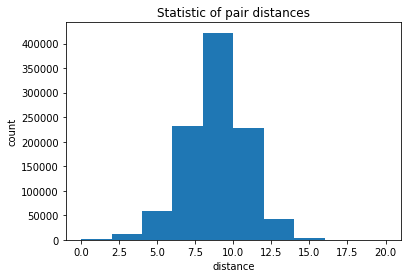

In [8]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
outputinfo_di(G)
S = G.number_of_nodes()
dijkstra_path_length, subset = get_dijkstra_path_length_sub(G, S)
thedistance_info(dijkstra_path_length, subset)

In [10]:
klist = [8, 12, 16, 18, 20, 22, 24, 26, 30]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

#########Test for K:8
Pool size: 8
0.5012008580826657
(8782.0, 266.0, 989952.0)
#########Test for K:12
Pool size: 8
0.372647460629125
(53438.0, 1326.0, 944236.0)
#########Test for K:16
Pool size: 8
0.2767575694288662
(144298.0, 2912.0, 851790.0)
#########Test for K:18
Pool size: 8
0.23786263735076402
(225838.0, 3762.0, 769400.0)
#########Test for K:20
Pool size: 8
0.2099883946069815
(313660.0, 4492.0, 680848.0)
#########Test for K:22
Pool size: 8
0.2092371513647314
(496224.0, 4718.0, 498058.0)
#########Test for K:24
Pool size: 8
0.20654253984146287
(585238.0, 4818.0, 408944.0)
#########Test for K:26
Pool size: 8
0.22514236957659028
(669550.0, 4518.0, 324932.0)
#########Test for K:30
Pool size: 8
0.3303014877369826
(874156.0, 2574.0, 122270.0)


In [11]:
klist = [8, 12, 16, 18, 20, 22, 24, 26, 30]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

#########Test for K:8
Pool size: 8
0.45384602831847864
(23018.0, 576.0, 975406.0)
#########Test for K:12
Pool size: 8
0.33396690739417656
(88978.0, 1678.0, 908344.0)
#########Test for K:16
Pool size: 8
0.23697171131588224
(255628.0, 3298.0, 740074.0)
#########Test for K:18
Pool size: 8
0.22161151768512727
(291450.0, 3596.0, 703954.0)
#########Test for K:20
Pool size: 8
0.20108323705522851
(435696.0, 4170.0, 559134.0)
#########Test for K:22
Pool size: 8
0.20723974421809943
(565766.0, 4134.0, 429100.0)
#########Test for K:24
Pool size: 8
0.2722442403419807
(736688.0, 3226.0, 259086.0)
#########Test for K:26
Pool size: 8
0.3734901581802546
(859206.0, 2168.0, 137626.0)
#########Test for K:30
Pool size: 8
0.42737388012410693
(942196.0, 1264.0, 55540.0)


In [12]:
klist = [4, 5, 6, 7, 8, 9, 10, 11, 12]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

#########Test for K:4
Pool size: 8
0.6175896274645629
(10754.0, 3552.0, 984694.0)
#########Test for K:5
Pool size: 8
0.5151945622119313
(37102.0, 9910.0, 951988.0)
#########Test for K:6
Pool size: 8
0.4317871362984479
(97300.0, 18950.0, 882750.0)
#########Test for K:7
Pool size: 8
0.35365192546983565
(196416.0, 29700.0, 772884.0)
#########Test for K:8
Pool size: 8
0.3071545799724957
(341746.0, 36846.0, 620408.0)
#########Test for K:9
Pool size: 8
0.3009547840107576
(438782.0, 38822.0, 521396.0)
#########Test for K:10
Pool size: 8
0.32134281337149695
(566288.0, 37534.0, 395178.0)
#########Test for K:11
Pool size: 8
0.4196595195549925
(742926.0, 29012.0, 227062.0)
#########Test for K:12
Pool size: 8
0.5211875798588197
(847088.0, 20630.0, 131282.0)


In [13]:
klist = [6, 7, 8, 9, 10, 11]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.01
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results[0])
    print(results[1:])

#########Test for K:6
Pool size: 8
0.40452182206220033
(115552.0, 37932.0, 845516.0)
#########Test for K:7
Pool size: 8
0.33920761183369313
(281656.0, 57470.0, 659874.0)
#########Test for K:8
Pool size: 8
0.31046752720350723
(323898.0, 64330.0, 610772.0)
#########Test for K:9
Pool size: 8
0.33615371339063993
(511342.0, 63414.0, 424244.0)
#########Test for K:10
Pool size: 8
0.4638596732603188
(720032.0, 48992.0, 229976.0)
#########Test for K:11
Pool size: 8
0.47726665019269304
(775934.0, 44404.0, 178662.0)


**Conclusion on directed graph**

- As for dimention $K$


1. For both $L_1$, $L_2$ and `average`, `max`: the distortion first decrease and later increase, and when it reaches the best one, the comparsion show nearly half of the prediction are larger than real distances while the other half are smaller.
    - The reason is the algorithm here doesn't make sure the **information** decrease on the graph, which is different from the $L_1$ version of undirected graph. Thus the bigger the dimension, the bigger the predicted distance.
    - **Attention**: we need to prove this algorithm cannot end by $\epsilon$
2. $L_1$ (8) can reach its best distortion with **smaller** $K$ than $L_2$ (20), but $L_2$ get the better distortion for whole.
    - **Attention**: we need to understand the reason here by theoretically compare the features of $L_1$ and $L_2$ algorithms
3. Both of $L_1$, $L_2$ requires the target to be symmetry and obey the triangular inequality, which means `diff` is not promissing. So foget about it.


- Other concerns:


1. What's the performance of proximating "$\min\{d_{ij}, d_{ji}\}$"
    - We may need different $K_1$, $K_2$ for `average`, `max`, and we should choose each of them the best one, otherwise the distortion can only become bigger from the whole view.
    - This is the same for choosing $L_2$ norm rather than $L_1$, unless there is some property under the algorithms.
    - The result have been tested at [RandomGraph](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb)
2. The performance is not stable when choosing different pivots.
    - Choosing the farthest pair of nodes is the idea carried by Data Mining FastMap, which is because it can be the best way to differential nodes after one dimension reduction.
    - However, is this still works good when we have a general graph, where the space is more complex?
    - **Attention**: We need to have a discussion on how to choose pivots.
3. Have a test on undirected graph, which can help knowing what's the ideal embedding. **Experiments**